In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import numpy as np 
from sklearn.datasets import load_wine
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix

#### PCA feature extraction 
Goal here is to make the features un-correlated (i.e., projected in the eigen-basis) so that Naive Bayes classifier can be applied

In [3]:
class PCA_feat_extract:
    
    def __init__(self, data_mat, is_subtract_mean=True):
        """ Implementation of Princial Component Analysis technique 
            :param data_mat: data matrix which is assumed to be of 'num_samples x num_feats' format 
            :param is_subtract_mean: whether to remove mean from each feature 
        """
        self.is_subtract_mean = is_subtract_mean
        if self.is_subtract_mean:
            # save the mean values since it is going to used later for reconstruction
            print("subtracting mean from data matrix...")
            self.data_mat_means = data_mat.mean(axis=0)
            data_mat -= self.data_mat_means
        self.data_mat = data_mat.T
        print(f"shape of the data matrix (num_feats x num_samples) {self.data_mat.shape}")
        
    def compute_cov(self, is_plot_cov=True):
        """ Compute covariance matrix of a data matrix 
            :param is_plot_cov: whether to plot covariance matrix
        """
        print("computing covariance matrix...")
        self.cov_mat = np.cov(self.data_mat)
        
        if is_plot_cov:
            self._plot_cov(self.cov_mat)
            
    def _plot_cov(self, cov_mat):
        """ Plot covariance matrix """
        print(f"plotting covariance matrix with dim: {cov_mat.shape}...")
        plt.imshow(cov_mat)
        plt.title("Covariance matrix")
        plt.colorbar()
        plt.show()
            
    def _sort_eigen_descend(self, eigen_vals, eigen_vecs):
        """ Sort eigenvalue and eigenvetor matrices according to eigenvalues in a descending order """ 
        print("sorting eigenvalue and eigenvector according to eigenvalues in a descending order...")
        # get the indices in descending order from eigen values
        inds_descend = np.flip(np.argsort(eigen_vals))
        
        # in the same order, sort eigen values and eigen vectors
        eigen_vals = eigen_vals[inds_descend]
        eigen_vecs = eigen_vecs[:, inds_descend] 
        
        return eigen_vals, eigen_vecs

    def compute_eigen(self):
        """ Computes eigenvalues and eigenvectors of a covariance matrix and sort them 
            according to the eigenvalues in a descending order 
        """
        print("computing eigenvalues and eigenvectors of a covariance matrix...")
        # compute eigenvalues and eigenvectors
        eigen_vals, eigen_vecs = np.linalg.eig(self.cov_mat)
        
        # sort both according to eigen values in a descending order 
        self.eigen_vals, self.eigen_vecs = self._sort_eigen_descend(eigen_vals, eigen_vecs)
        
        # plot eigenvalues (explained variances) in a descending and cumulative plot     
        tot_val = sum(self.eigen_vals)
        var_vals = [(var_val/tot_val) for var_val in self.eigen_vals]
        cum_var_vals = np.cumsum(var_vals)

        plt.figure(figsize=(10, 7))
        plt.bar(range(1, self.cov_mat.shape[0]+1), var_vals, alpha=0.5, 
                label='explained variance of each component')
        plt.step(range(1, self.cov_mat.shape[0]+1), cum_var_vals, 
                 label='explained variance of each component')

        plt.title("variance explained by components")
        plt.xlabel("principal components")
        plt.ylabel("explained variance")
        plt.xlim(0, self.cov_mat.shape[0])
        plt.ylim(0, 1)
        plt.legend(loc='upper left')
        plt.grid(linestyle='--')
        plt.show()
            
    def transform_train_data(self, num_comps=10, is_plot_cov=True):
        """ Compute projected data matrix using the number of components 
            :param num_comps: number of highest eigenvectors to keep 
            :param is_plot_cov: whether to plot covariance matrix of the projected data matrix 
        """
        if num_comps > self.cov_mat.shape[0]:
            print(f"max number of components possible is {self.cov_mat.shape[0]} and provided is {num_comps}")
            num_comps = self.cov_mat.shape[0] 
            
        print(f"computing projected data matrix acc to number of components {num_comps} to keep...")
        # project the original data matrix onto (reduced) eigen vectors 
        self.eigen_vecs_basis = self.eigen_vecs[:, :num_comps] 
        self.proj_data_mat = np.dot(self.eigen_vecs_basis.T, self.data_mat)
        
        # plot the covariance of the project data matrix. Note: it should be diagonal and each 
        # diagonal elements should be in descending order 
        if is_plot_cov:
            cov_mat = np.cov(self.proj_data_mat)
            self._plot_cov(cov_mat)
        print(f"shape of the projected data matrix: {self.proj_data_mat.shape}")
        
        # return the projected data of shape: num_samples x num_feats 
        return self.proj_data_mat.T
    
    def transform_test_data(self, data_to_proj):
        """ Project data matrix to the eigen basis """
        proj_data_mat = np.dot(self.eigen_vecs_basis.T, data_to_proj.T)
        return proj_data_mat.T

#### Naive Bayes classifier with Gaussian distribution

In [4]:
class NaiveBayesGauss:
    """ Naive Bayes classification using Gaussian distribution """
    
    def __init__(self):
        self.class_prior = {} 
        self.train_params = {} 
    
    def _compute_params(self, feat_df):
        """ compute training parameters: mean and std per feature """
        training_params = {}
        
        # compute mean and std per column (i.e., feature)
        mean_vec = feat_df.mean()
        mean_vec = mean_vec.drop("labels").to_dict()
        
        std_vec = feat_df.std() 
        std_vec = std_vec.drop("labels").to_dict() 
        
        for key, val in mean_vec.items():
            training_params[key] = (val, std_vec[key])
        
        return training_params
    
    def fit(self, X_train, y_train, show_samples=True):
        """ train a Naive Bayes classifier with Gaussian distribution 
        :param X_train: training data in the format (num_samples x num_features)
        :param y_train: a list of labels for the corresponding samples 
        """
        # create a pandas dataframe 
        num_samples, num_feats = X_train.shape 
        data_mat = np.column_stack((X_train, y_train))
        self.cols = ["feat" + str(i+1) for i in range(num_feats)] + ["labels"] 
        df = pd.DataFrame(data=data_mat, columns=self.cols)
        if show_samples:
            print("training data \n", df.head())
        
        # compute class priors and training params (mean and std) per feature per class 
        for label, feats_per_class in df.groupby('labels'):
            print(f"number of samples per class ({label}): {len(feats_per_class)}")
            self.class_prior[int(label)] = round(len(feats_per_class) / num_samples, 3) 
            self.train_params[int(label)] = self._compute_params(feats_per_class)
        
    def _compute_prob(self, x, label, feat_id):
        """ compute a Gaussian probability for a given feature value and for a given class label. 
            Gaussian parameters (mean and std) are computed from the training data 
        """
        feat_mean = self.train_params[label][self.cols[feat_id]][0]
        feat_std = self.train_params[label][self.cols[feat_id]][1] 
        
        exp_part = math.exp(-((x-feat_mean)**2 / (2 * feat_std**2 )))
        gauss_prob = (1 / (math.sqrt(2 * math.pi) * feat_std)) * exp_part
        return gauss_prob
    
    def _compute_likelihood_prob(self, feat_vec, label):
        """ compute a likelihood prob which is a product of probabilities of each feature variable for a given class label """
        likelihood_probs = [self._compute_prob(feat, label, feat_id) for feat_id, feat in enumerate(feat_vec)]
        return np.prod(likelihood_probs)
    
    def predict(self, X_test):
        """ prediction on a given test data 
        :param X_test: numpy array containing samples of feature vectors 
        :return predict_vals: predicted label and probabilities 
        """
        # convert numpy array to a list of lists
        X_test = X_test.tolist() 
        predict_vals = {"probs": [], "labels": []}
        
        # compute max posterior prob for each sample 
        for ind, sample in enumerate(X_test):
            
            # compute posterior probabilities for each class and pick the max one as final class label 
            predict_prob = -1
            predict_label = -1
            norm_constant = 0.0 
            for label, prior_prob in self.class_prior.items():
                # compute likelihood prob which is a product of probs of each feature 
                likelihood_prob = self._compute_likelihood_prob(sample, label)
                
                # compute posterior distrition as multiplication of prior and likelihood. Note: normalization constant 
                # since we will compute the max prob afterwards 
                post_prob = prior_prob * likelihood_prob 
                
                # compute normalization constant 
                norm_constant += post_prob 
                if post_prob > predict_prob:
                    predict_prob = post_prob 
                    predict_label = label 
                    
            print(f"predicted label for the {ind}th sample is {predict_label} with probability {predict_prob}")
            predict_vals["probs"].append(predict_prob / norm_constant)
            predict_vals["labels"].append(predict_label) 
            
        # return the label with the max probability 
        return predict_vals

#### 1. Load the wine data. Note that this data is not normalized at all. 

In [5]:
wine_data = load_wine()
data = wine_data.data 
labels = wine_data.target

#### 2. First scale the data along each feature to have zero mean and unit variance

In [6]:
data = (data - data.mean(axis=0)) / data.std(axis=0)

#### 3. Split the data into training and test 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=0)

#### 4. Compute un-correlated features using PCA with no diemnsional reduction

In [8]:
pca_feat = PCA_feat_extract(X_train)

subtracting mean from data matrix...
shape of the data matrix (num_feats x num_samples) (13, 142)


computing covariance matrix...
plotting covariance matrix with dim: (13, 13)...


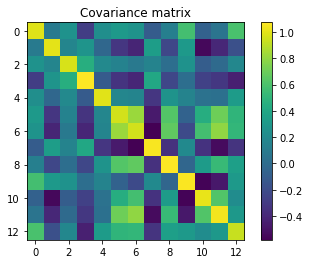

computing eigenvalues and eigenvectors of a covariance matrix...
sorting eigenvalue and eigenvector according to eigenvalues in a descending order...


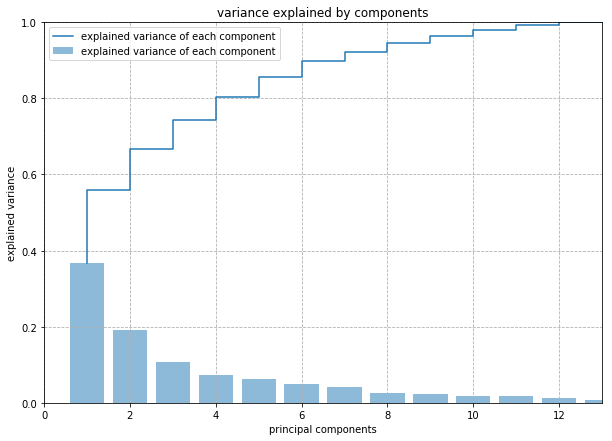

computing projected data matrix acc to number of components 2 to keep...
plotting covariance matrix with dim: (2, 2)...


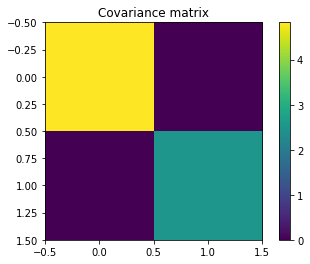

shape of the projected data matrix: (2, 142)


In [9]:
pca_feat.compute_cov()

pca_feat.compute_eigen()

X_train_proj = pca_feat.transform_train_data(num_comps=2) # ncomps=X_train.shape[1] 

X_test_proj = pca_feat.transform_test_data(X_test)

In [10]:
print(f"shape of the projected X_train: {X_train_proj.shape} and of the X_test {X_test_proj.shape}")

shape of the projected X_train: (142, 2) and of the X_test (36, 2)


#### Naive Bayes classifier

In [11]:
nb_classifier = NaiveBayesGauss()
nb_classifier.fit(X_train_proj, y_train)

training data 
       feat1     feat2  labels
0 -2.216277  0.999475     2.0
1 -1.769258 -1.613008     1.0
2  1.172307 -2.170643     1.0
3 -2.601498  1.609546     2.0
4  1.866049 -0.257468     0.0
number of samples per class (0.0): 45
number of samples per class (1.0): 55
number of samples per class (2.0): 42


#### Print the trained parameters

In [12]:
nb_classifier.class_prior

{0: 0.317, 1: 0.387, 2: 0.296}

In [13]:
nb_classifier.train_params

{0: {'feat1': (2.352498796660036, 0.8020758329997308),
  'feat2': (1.025787619433885, 0.8140334251450175)},
 1: {'feat1': (0.13895165342101218, 1.214244886537569),
  'feat2': (-1.672536573271403, 0.7979574590450416)},
 2: {'feat1': (-2.7024949235204114, 0.6230307958545166),
  'feat2': (1.0911683013191038, 1.0088243407185375)}}

#### Perform prediction on test dataset

In [14]:
predict_vals = nb_classifier.predict(X_test_proj)

predicted label for the 0th sample is 0 with probability 0.07329223219610322
predicted label for the 1th sample is 2 with probability 0.05513083716370773
predicted label for the 2th sample is 1 with probability 0.016361913724542595
predicted label for the 3th sample is 0 with probability 0.0681176469261764
predicted label for the 4th sample is 1 with probability 0.020659076105899603
predicted label for the 5th sample is 0 with probability 0.019191529904477322
predicted label for the 6th sample is 0 with probability 0.053971755723550896
predicted label for the 7th sample is 2 with probability 0.049821984786683086
predicted label for the 8th sample is 1 with probability 0.05077584605537806
predicted label for the 9th sample is 1 with probability 0.02820575887300062
predicted label for the 10th sample is 2 with probability 0.040554368748737
predicted label for the 11th sample is 2 with probability 0.002715632637058397
predicted label for the 12th sample is 0 with probability 0.01786775390

In [18]:
conf_mat = confusion_matrix(y_test, predict_vals["labels"])
print(conf_mat)

[[14  0  0]
 [ 1 15  0]
 [ 0  0  6]]


In [19]:
print(classification_report(y_test, predict_vals["labels"]))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.94      0.97        16
           2       1.00      1.00      1.00         6

   micro avg       0.97      0.97      0.97        36
   macro avg       0.98      0.98      0.98        36
weighted avg       0.97      0.97      0.97        36



In [24]:
acc = 1 - (np.sum(conf_mat) - np.trace(conf_mat))/np.sum(conf_mat)
print(f"accuracy rate: {round(acc*100.0, 3)}")

accuracy rate: 97.222
